# Forecasting with Temporian and TensorFlow Decision Forests

## Install and import dependencies


In [ ]:
%pip install temporian -q

# The Bokeh package is used by Temporian to create interactive plots.
# If if Bokeh is not installed, Temporian plots are static.
%pip install bokeh -q

In [1]:
import os
import pandas as pd
import temporian as tp
import datetime
import concurrent.futures

In [2]:
start_date = datetime.date(2018, 4, 1)
end_date = datetime.date(2018, 4, 30)
#end_date = datetime.date(2018, 9, 30)

filenames = []
while start_date <= end_date:
    filenames.append(f"{start_date}")
    start_date += datetime.timedelta(days=1)
print(f"{len(filenames)} dates")

30 dates


In [18]:
def load_date(filename):
    print(".",end="", flush=True)
    return pd.read_pickle(f"https://github.com/Fraud-Detection-Handbook/simulated-data-raw/raw/main/data/{filename}.pkl")

print("Loading dataset",end="")
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    frames = executor.map(load_date, filenames)
pandas_dataset = pd.concat(frames)
print("done")
print(f"Found {len(pandas_dataset)} transactions")

Loading dataset..............................done
Found 288062 transactions


In [4]:
pandas_dataset

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0
...,...,...,...,...,...,...,...,...,...
288057,288057,2018-04-30 23:56:58,818,7690,48.92,2591818,29,0,0
288058,288058,2018-04-30 23:57:38,3763,7460,99.06,2591858,29,0,0
288059,288059,2018-04-30 23:57:39,2000,8998,83.24,2591859,29,0,0
288060,288060,2018-04-30 23:58:01,2566,6688,109.55,2591881,29,0,0


In [19]:
pandas_dataset["TX_FRAUD_SCENARIO"].value_counts()

0    286360
2       931
3       603
1       168
Name: TX_FRAUD_SCENARIO, dtype: int64

In [20]:
pandas_dataset["TX_FRAUD"].value_counts()

0    286360
1      1702
Name: TX_FRAUD, dtype: int64

In [21]:
pandas_dataset[pandas_dataset["TX_FRAUD"] == 1]

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
3527,3527,2018-04-01 10:17:43,3774,3059,225.41,37063,0,1,1
5790,5790,2018-04-01 13:31:48,4944,6050,222.26,48708,0,1,1
6549,6549,2018-04-01 14:42:02,4625,9102,226.40,52922,0,1,1
9583,9583,2018-04-02 01:01:05,3814,6893,59.15,90065,1,1,3
10355,10355,2018-04-02 05:03:35,2513,1143,222.04,104615,1,1,1
...,...,...,...,...,...,...,...,...,...
287518,287518,2018-04-30 20:19:52,1941,3884,391.40,2578792,29,1,3
287669,287669,2018-04-30 21:03:02,2439,8821,43.95,2581382,29,1,3
287685,287685,2018-04-30 21:06:54,3391,5185,96.52,2581614,29,1,2
287893,287893,2018-04-30 22:17:05,3416,1764,117.42,2585825,29,1,2


In [5]:
pandas_dataset = pandas_dataset[["TX_DATETIME", "CUSTOMER_ID", "TERMINAL_ID", "TX_AMOUNT", "TX_FRAUD"]]

In [6]:
dataset = tp.from_pandas(pandas_dataset, timestamps="TX_DATETIME")

In [7]:
dataset

indexes: []
features: [('CUSTOMER_ID', str_), ('TERMINAL_ID', str_), ('TX_AMOUNT', float64), ('TX_FRAUD', int64)]
events:
     (288062 events):
        timestamps: [1.5225e+09 1.5225e+09 1.5225e+09 ... 1.5251e+09 1.5251e+09 1.5251e+09]
        'CUSTOMER_ID': ['596' '4961' '2' ... '2000' '2566' '1274']
        'TERMINAL_ID': ['3156' '3412' '1365' ... '8998' '6688' '4535']
        'TX_AMOUNT': [ 57.16  81.51 146.   ...  83.24 109.55  79.02]
        'TX_FRAUD': [0 0 0 ... 0 0 0]
memory usage: 16.1 MB

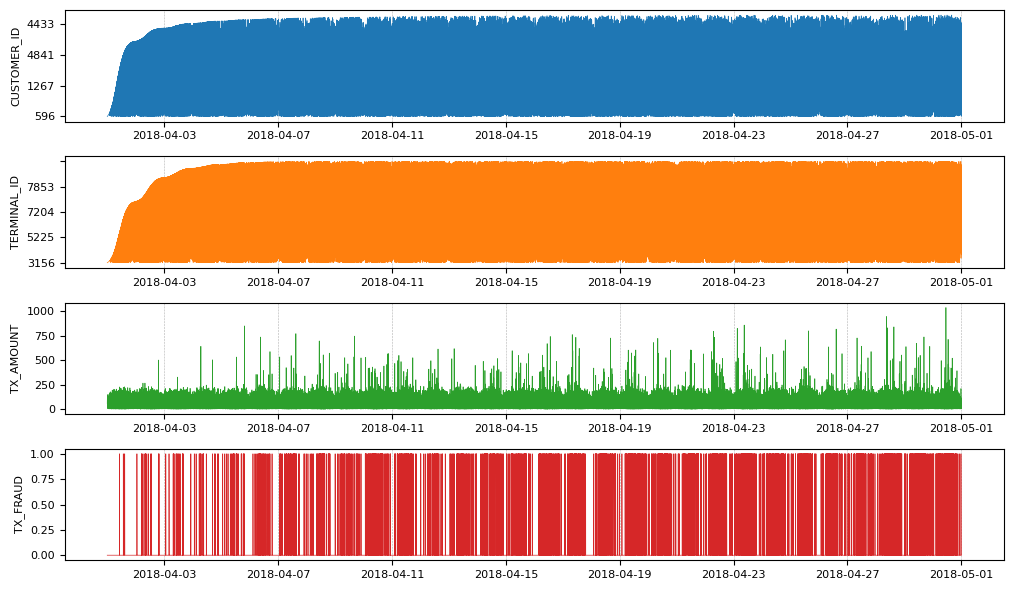

In [8]:
dataset.plot()

Build schedule
Run 1 operators
    1 / 1: ADD_INDEX [0.25080 s]
Execution in 0.25099 s


The number of plots (14877) is larger than "options.max_num_plots=4". Only the first plots will be printed.


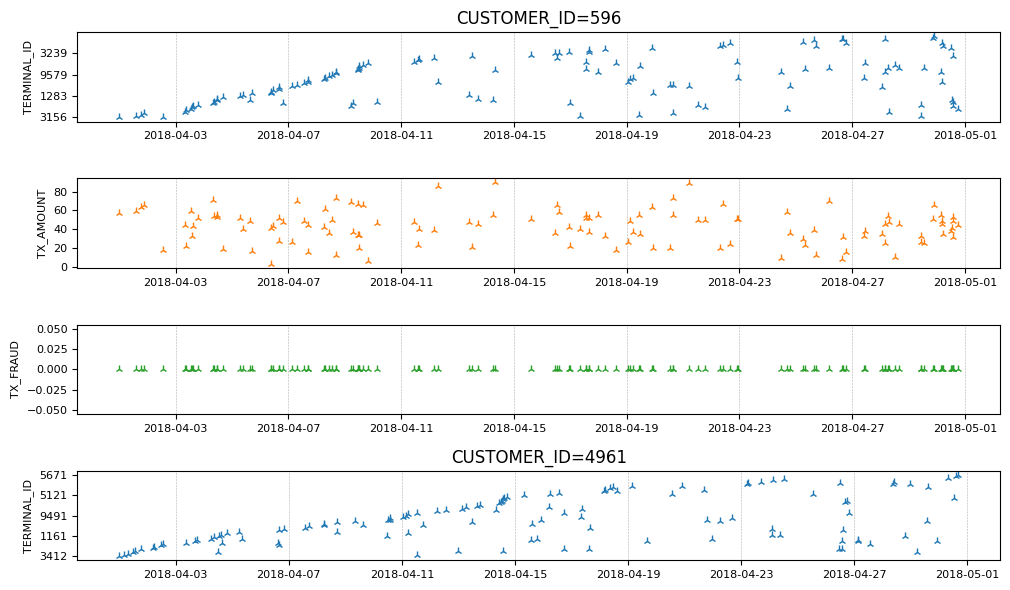

In [9]:
dataset_node = dataset.node()
#x = tp.filter(dataset_node, tp.equal(dataset_node["CUSTOMER_ID"], "596"))
x = tp.add_index(dataset_node, ["CUSTOMER_ID"])

x.evaluate(dataset).plot(max_num_plots=4)

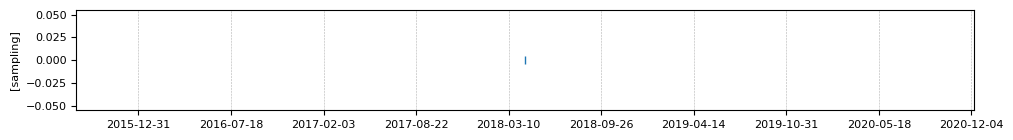

In [10]:
train_test_limit = tp.event_set(timestamps=["2018-04-15"])

train_test_limit.plot()

Build schedule
Run 3 operators
    1 / 3: SINCE_LAST [0.00047 s]
    2 / 3: IS_NAN [0.00091 s]
    3 / 3: FILTER [0.00240 s]
Execution in 0.00417 s


The number of plots (4) is larger than "options.max_num_plots=1". Only the first plots will be printed.


Build schedule
Run 4 operators
    1 / 4: SINCE_LAST [0.00045 s]
    2 / 4: IS_NAN [0.00033 s]
    3 / 4: INVERT [0.00006 s]
    4 / 4: FILTER [0.00159 s]
Execution in 0.00281 s


The number of plots (4) is larger than "options.max_num_plots=1". Only the first plots will be printed.


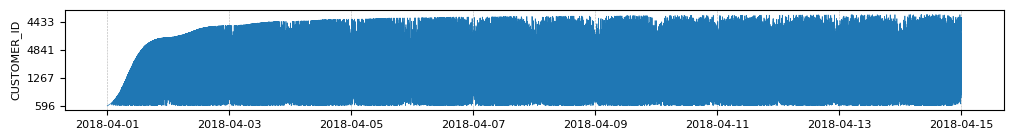

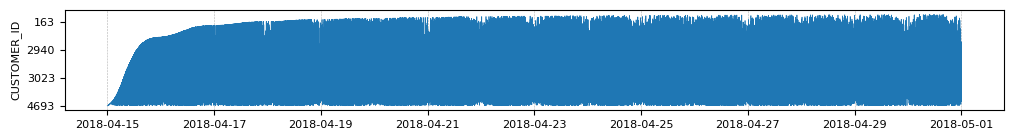

In [11]:
is_train_node = tp.isnan(tp.since_last(train_test_limit.node(), dataset_node))
is_test_node = tp.invert(is_train_node)

tp.filter(dataset_node, is_train_node).evaluate([dataset, train_test_limit]).plot(max_num_plots=1)
tp.filter(dataset_node, is_test_node).evaluate([dataset, train_test_limit]).plot(max_num_plots=1)

In [12]:
# Per client, and per terminal
# sum and ratio of fraud over the last X  days.
# Delay of 1 week before the fraud information is available

Build schedule
Run 5 operators
    1 / 5: ADD_INDEX [0.27771 s]
    2 / 5: SELECT [0.01263 s]
    3 / 5: LAG [0.01633 s]
    4 / 5: CAST [0.01835 s]
    5 / 5: MOVING_SUM [0.05388 s]
Execution in 0.37981 s


The number of plots (4959) is larger than "options.max_num_plots=10". Only the first plots will be printed.


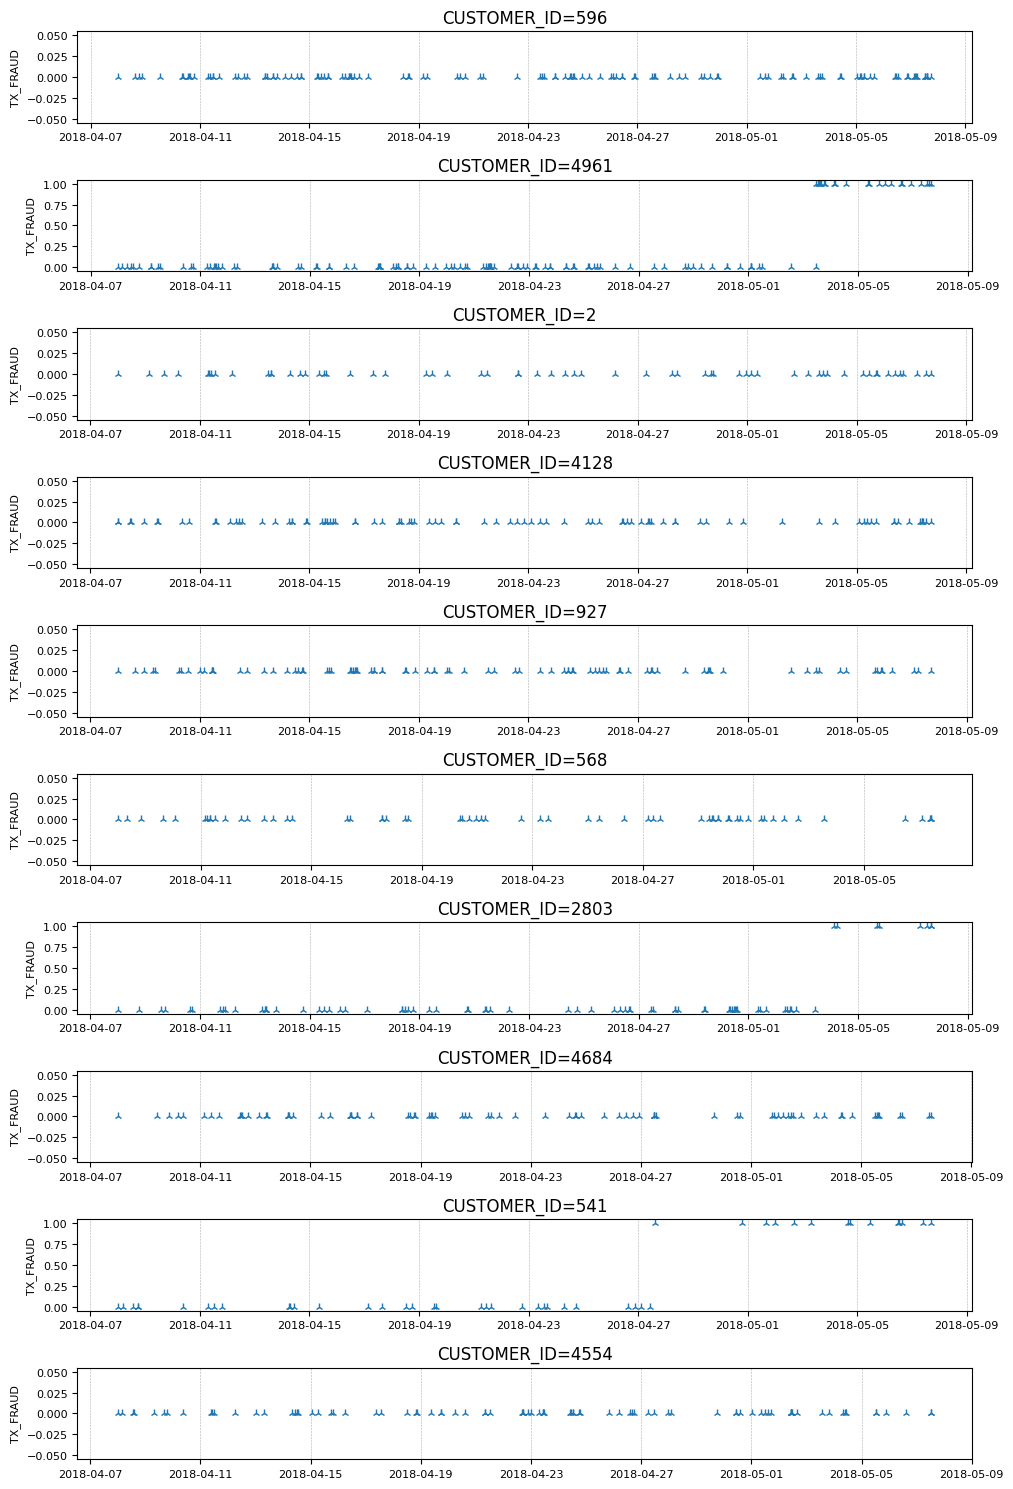

In [32]:
#x = tp.filter(dataset_node, tp.equal(dataset_node["CUSTOMER_ID"], "3774"))
x = dataset_node

#x = tp.add_index(x, "TERMINAL_ID")
x = tp.add_index(x, "CUSTOMER_ID")

fraud = tp.lag(x["TX_FRAUD"], tp.duration.weeks(1))
feature = tp.moving_sum(tp.cast(fraud, tp.float32), tp.duration.weeks(4))#, sampling=x)

feature.evaluate(dataset).plot(max_num_plots=10, )


# EQ
# dataset_node.add_index("CUSTOMER_ID")["TX_FRAUD"].lag(tp.duration.weeks(1)).cast(tp.float32).moving_sum(tp.duration.weeks(4))